<a href="https://colab.research.google.com/github/Deepikadandolu/internproject2/blob/main/rp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np


In [ ]:
# Load
df = pd.read_csv("/content/drive/MyDrive/837 - Sheet1.csv")

# Clean column names
df.columns = df.columns.str.replace(";", "").str.strip()

# Columns
TIME_COL = "Timestamp [ms]"
CPU_COL  = "CPU usage [%]"
MEM_COL  = "Memory usage [KB]"

# Parse time (paper assumes UNIX timestamp)
df[TIME_COL] = pd.to_datetime(df[TIME_COL], unit="s")
df.set_index(TIME_COL, inplace=True)
df.sort_index(inplace=True)

# Numeric safety
df[CPU_COL] = pd.to_numeric(df[CPU_COL], errors="coerce")
df[MEM_COL] = pd.to_numeric(df[MEM_COL], errors="coerce")


In [ ]:
cpu_mem_10min = (
    df[[CPU_COL, MEM_COL]]
    .resample("10min")
    .mean()
    .dropna()
)

cpu_mem_1h = (
    df[[CPU_COL, MEM_COL]]
    .resample("1H")
    .mean()
    .dropna()
)

print("10-min rows:", len(cpu_mem_10min))  # ~4320
print("1-hour rows:", len(cpu_mem_1h))     # ~721


10-min rows: 4320
1-hour rows: 721


/tmp/ipython-input-2147734448.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("1H")


In [ ]:
def create_sample_chunks(df, window, step):
    return [
        df.iloc[i:i+window]
        for i in range(0, len(df) - window + 1, step)
    ]


In [ ]:
# 10-minute data (~30 days)
WINDOW_10MIN = 720   # 5 days
STEP_10MIN   = 288   # 2 days

# 1-hour data (~30 days)
WINDOW_1H = 168      # 7 days
STEP_1H   = 72       # 3 days


In [ ]:
chunks_10min = create_sample_chunks(
    cpu_mem_10min,
    WINDOW_10MIN,
    STEP_10MIN
)

chunks_1h = create_sample_chunks(
    cpu_mem_1h,
    WINDOW_1H,
    STEP_1H
)

print("10-min chunks:", len(chunks_10min))
print("1-hour chunks:", len(chunks_1h))


10-min chunks: 13
1-hour chunks: 8


In [ ]:
def split_train_test(series, ratio=0.9):
    n = int(len(series) * ratio)
    return series.iloc[:n], series.iloc[n:]


In [ ]:
chunk = chunks_10min[0]

train_cpu, test_cpu = split_train_test(chunk[CPU_COL])
train_mem, test_mem = split_train_test(chunk[MEM_COL])


In [ ]:
import numpy as np

def smape(y_true, y_pred):
    return np.mean(
        np.abs(y_true - y_pred) /
        ((np.abs(y_true) + np.abs(y_pred)) / 2)
    ) * 100


In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import warnings

warnings.simplefilter("ignore", ConvergenceWarning)


In [ ]:
def train_hw(train_series, seasonal_period):
    model = ExponentialSmoothing(
        train_series,
        trend="add",
        seasonal="add",
        seasonal_periods=seasonal_period,
        initialization_method="estimated"
    )
    return model.fit(optimized=True)


In [ ]:
def rolling_hw_forecast(train, test, seasonal_period):
    history = train.copy()   # pandas Series
    preds = []

    for t in range(len(test)):
        model = train_hw(history, seasonal_period)

        # forecast may return ndarray or Series → index safely
        y_hat = model.forecast(1)[0]
        preds.append(y_hat)

        # append true value (keep pandas type)
        history = pd.concat([
            history,
            test.iloc[t:t+1]
        ])

    return np.array(preds)




In [ ]:
def split_train_test(series, ratio=0.9):
    n = int(len(series) * ratio)
    return series.iloc[:n], series.iloc[n:]


In [ ]:
SEASONAL_10MIN = 144

hw_cpu_10_results = []

for i, chunk in enumerate(chunks_10min):

    cpu_series = chunk["CPU usage [%]"]

    train_cpu, test_cpu = split_train_test(cpu_series)

    preds = rolling_hw_forecast(
        train_cpu,
        test_cpu,
        SEASONAL_10MIN
    )

    error = smape(test_cpu.values, preds)

    hw_cpu_10_results.append({
        "chunk_id": i,
        "smape": error
    })


/tmp/ipython-input-1068194721.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_hat = model.forecast(1)[0]
/tmp/ipython-input-1068194721.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_hat = model.forecast(1)[0]
/tmp/ipython-input-1068194721.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_hat = model.forecast(1)[0]
/tmp/ipython-input-1068194721.py:9: FutureWarning: Series.__getitem__ treating keys as positions is dep

In [ ]:
hw_cpu_10_df = pd.DataFrame(hw_cpu_10_results)
hw_cpu_10_df.describe()


,chunk_id,smape
count,13.00000,13.000000
mean,6.00000,199.048594
std,3.89444,0.830680
min,0.00000,198.111455
25%,3.00000,198.222665
50%,6.00000,198.890659
75%,9.00000,200.000000
max,12.00000,200.000000


In [ ]:
SEASONAL_1H = 24

hw_cpu_1h_results = []

for i, chunk in enumerate(chunks_1h):

    cpu_series = chunk["CPU usage [%]"]

    train_cpu, test_cpu = split_train_test(cpu_series)

    preds = rolling_hw_forecast(
        train_cpu,
        test_cpu,
        SEASONAL_1H
    )

    error = smape(test_cpu.values, preds)

    hw_cpu_1h_results.append({
        "chunk_id": i,
        "smape": error
    })


/tmp/ipython-input-1068194721.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_hat = model.forecast(1)[0]
/tmp/ipython-input-1068194721.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_hat = model.forecast(1)[0]
/tmp/ipython-input-1068194721.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_hat = model.forecast(1)[0]
/tmp/ipython-input-1068194721.py:9: FutureWarning: Series.__getitem__ treating keys as positions is dep

In [ ]:
hw_cpu_1h_df = pd.DataFrame(hw_cpu_1h_results)
hw_cpu_1h_df.describe()


,chunk_id,smape
count,8.00000,8.000000
mean,3.50000,188.415729
std,2.44949,0.099045
min,0.00000,188.317227
25%,1.75000,188.344539
50%,3.50000,188.385872
75%,5.25000,188.459831
max,7.00000,188.577692


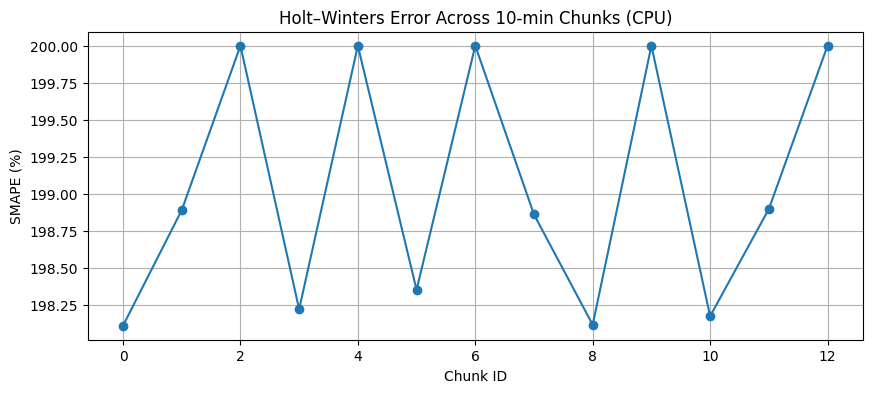

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(hw_cpu_10_df["chunk_id"], hw_cpu_10_df["smape"], marker="o")
plt.xlabel("Chunk ID")
plt.ylabel("SMAPE (%)")
plt.title("Holt–Winters Error Across 10-min Chunks (CPU)")
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense
from tensorflow.keras.optimizers import Adam


In [ ]:
def scale_series(train, test):
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
    test_scaled  = scaler.transform(test.values.reshape(-1, 1))
    return train_scaled, test_scaled, scaler


In [ ]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)


In [ ]:
def build_bilstm(input_shape):
    model = Sequential([
        Bidirectional(LSTM(32), input_shape=input_shape),
        Dense(1)
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="mse"
    )
    return model


In [ ]:
def rolling_forecast_bilstm(train, test, window_size):
    # Scale
    train_scaled, test_scaled, scaler = scale_series(train, test)

    # Supervised data
    X_train, y_train = create_sequences(train_scaled, window_size)

    # Train model ONCE
    model = build_bilstm((window_size, 1))
    model.fit(
        X_train, y_train,
        epochs=40,
        batch_size=32,
        verbose=0
    )

    # Rolling forecast
    history = list(train_scaled.flatten())
    predictions = []

    for i in range(len(test_scaled)):
        x_input = np.array(history[-window_size:]).reshape(1, window_size, 1)
        yhat = model.predict(x_input, verbose=0)[0][0]
        predictions.append(yhat)

        # append TRUE value (paper rule)
        history.append(test_scaled[i][0])

    # Inverse scale
    predictions = scaler.inverse_transform(
        np.array(predictions).reshape(-1, 1)
    ).flatten()

    return predictions


In [ ]:
WINDOW_SIZE = 40


In [ ]:
bilstm_cpu_10_results = []

for i, chunk in enumerate(chunks_10min):

    cpu_series = chunk["CPU usage [%]"]

    train_cpu, test_cpu = split_train_test(cpu_series)

    preds = rolling_forecast_bilstm(
        train_cpu,
        test_cpu,
        WINDOW_SIZE
    )

    error = smape(test_cpu.values, preds)

    bilstm_cpu_10_results.append({
        "chunk_id": i,
        "smape": error
    })


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `

In [ ]:
bilstm_cpu_10_df = pd.DataFrame(bilstm_cpu_10_results)
bilstm_cpu_10_df.describe()


,chunk_id,smape
count,13.00000,13.000000
mean,6.00000,199.885626
std,3.89444,0.169065
min,0.00000,199.497449
25%,3.00000,199.937921
50%,6.00000,199.955847
75%,9.00000,199.960506
max,12.00000,199.966700


In [ ]:
bilstm_cpu_1h_results = []

for i, chunk in enumerate(chunks_1h):

    cpu_series = chunk["CPU usage [%]"]

    train_cpu, test_cpu = split_train_test(cpu_series)

    preds = rolling_forecast_bilstm(
        train_cpu,
        test_cpu,
        WINDOW_SIZE
    )

    error = smape(test_cpu.values, preds)

    bilstm_cpu_1h_results.append({
        "chunk_id": i,
        "smape": error
    })


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `

In [ ]:
bilstm_cpu_1h_df = pd.DataFrame(bilstm_cpu_1h_results)
bilstm_cpu_1h_df.describe()


,chunk_id,smape
count,8.00000,8.000000
mean,3.50000,194.265057
std,2.44949,0.658523
min,0.00000,193.250142
25%,1.75000,193.905622
50%,3.50000,194.291837
75%,5.25000,194.652197
max,7.00000,195.244362


In [ ]:
comparison_cpu_10 = pd.DataFrame({
    "Holt-Winters": hw_cpu_10_df["smape"],
    "Bi-LSTM": bilstm_cpu_10_df["smape"]
})

comparison_cpu_10.describe()


,Holt-Winters,Bi-LSTM
count,13.000000,13.000000
mean,199.048594,199.885626
std,0.830680,0.169065
min,198.111455,199.497449
25%,198.222665,199.937921
50%,198.890659,199.955847
75%,200.000000,199.960506
max,200.000000,199.966700


In [ ]:
class OSELM:
    def __init__(self, n_input, n_hidden):
        self.n_input = n_input
        self.n_hidden = n_hidden

        # Random hidden layer
        self.W = np.random.randn(n_input, n_hidden)
        self.b = np.random.randn(n_hidden)

        self.beta = None
        self.P = None

    def _hidden(self, X):
        return 1 / (1 + np.exp(-(X @ self.W + self.b)))

    def initialize(self, X_init, y_init):
        H = self._hidden(X_init)
        self.P = np.linalg.inv(H.T @ H + np.eye(self.n_hidden) * 1e-6)
        self.beta = self.P @ H.T @ y_init

    def update(self, X, y):
        H = self._hidden(X)
        PH = self.P @ H.T

        self.P = self.P - PH @ np.linalg.inv(
            np.eye(H.shape[0]) + H @ PH
        ) @ H @ self.P

        self.beta = self.beta + self.P @ H.T @ (y - H @ self.beta)

    def predict(self, X):
        return self._hidden(X) @ self.beta


In [ ]:
def prepare_oselm_data(series, window):
    X, y = [], []
    values = series.values

    for i in range(len(values) - window):
        X.append(values[i:i + window])
        y.append(values[i + window])

    return np.array(X), np.array(y)


In [ ]:
def rolling_forecast_oselm(train, test, window, n_hidden=35, init_size=100):

    X_train, y_train = prepare_oselm_data(train, window)

    X_test, y_test = prepare_oselm_data(
        pd.concat([train.iloc[-window:], test]),
        window
    )

    model = OSELM(window, n_hidden)
    model.initialize(
        X_train[:init_size],
        y_train[:init_size].reshape(-1, 1)
    )

    preds = []

    for i in range(len(X_test)):
        y_hat = model.predict(X_test[i:i+1])[0, 0]
        preds.append(y_hat)

        model.update(
            X_test[i:i+1],
            np.array([[y_test[i]]])
        )

    return np.array(preds)


In [ ]:
oselm_cpu_10_results = []

for i, chunk in enumerate(chunks_10min):

    cpu_series = chunk["CPU usage [%]"]

    train_cpu, test_cpu = split_train_test(cpu_series)

    preds = rolling_forecast_oselm(
        train_cpu,
        test_cpu,
        window=WINDOW_SIZE
    )

    y_true = pd.concat([
        train_cpu.iloc[-WINDOW_SIZE:],
        test_cpu
    ]).values[WINDOW_SIZE:]

    error = smape(y_true, preds)

    oselm_cpu_10_results.append({
        "chunk_id": i,
        "smape": error
    })


In [ ]:
oselm_cpu_10_df = pd.DataFrame(oselm_cpu_10_results)
oselm_cpu_10_df.describe()


,chunk_id,smape
count,13.00000,13.000000
mean,6.00000,199.714159
std,3.89444,0.417204
min,0.00000,198.845719
25%,3.00000,199.923458
50%,6.00000,199.930460
75%,9.00000,199.932558
max,12.00000,199.937787


In [ ]:
def mean_ensemble(preds_list):
    return np.mean(preds_list, axis=0)


In [ ]:
def adaptive_ensemble(pred_matrix, y_true, alpha=0.9):
    T, M = pred_matrix.shape
    weights = np.ones(M) / M
    ensemble_preds = []

    for t in range(T):
        y_hat = np.dot(weights, pred_matrix[t])
        ensemble_preds.append(y_hat)

        errors = np.abs(pred_matrix[t] - y_true[t]) + 1e-6
        new_weights = 1 / errors
        new_weights /= new_weights.sum()

        weights = alpha * weights + (1 - alpha) * new_weights

    return np.array(ensemble_preds)


In [ ]:
# Use first chunk for illustration (paper-style)
chunk = chunks_10min[0]
cpu_series = chunk["CPU usage [%]"]

train_cpu, test_cpu = split_train_test(cpu_series)

# Predictions from previous phases
hw_preds     = rolling_hw_forecast(train_cpu, test_cpu, 144)
bilstm_preds = rolling_forecast_bilstm(train_cpu, test_cpu, WINDOW_SIZE)

oselm_preds = rolling_forecast_oselm(
    train_cpu,
    test_cpu,
    WINDOW_SIZE
)[-len(test_cpu):]

y_true = test_cpu.values


/tmp/ipython-input-1068194721.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_hat = model.forecast(1)[0]
/tmp/ipython-input-1068194721.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_hat = model.forecast(1)[0]
/tmp/ipython-input-1068194721.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_hat = model.forecast(1)[0]
/tmp/ipython-input-1068194721.py:9: FutureWarning: Series.__getitem__ treating keys as positions is dep

In [ ]:
mean_preds = mean_ensemble([
    hw_preds,
    bilstm_preds,
    oselm_preds
])

mean_smape = smape(y_true, mean_preds)


In [ ]:
pred_matrix = np.column_stack([
    hw_preds,
    bilstm_preds,
    oselm_preds
])

adaptive_preds = adaptive_ensemble(
    pred_matrix,
    y_true
)

adaptive_smape = smape(y_true, adaptive_preds)


In [ ]:
final_results = pd.DataFrame({
    "Model": [
        "Holt-Winters",
        "Bi-LSTM",
        "OS-ELM",
        "Mean Ensemble",
        "Adaptive Ensemble"
    ],
    "SMAPE (%)": [
        smape(y_true, hw_preds),
        smape(y_true, bilstm_preds),
        smape(y_true, oselm_preds),
        mean_smape,
        adaptive_smape
    ]
})

final_results


,Model,SMAPE (%)
0,Holt-Winters,198.111455
1,Bi-LSTM,199.967115
2,OS-ELM,199.930446
3,Mean Ensemble,199.161013
4,Adaptive Ensemble,198.593843


In [ ]:
from sklearn.metrics import mean_squared_error

def mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def smape(y_true, y_pred):
    return np.mean(
        np.abs(y_true - y_pred) /
        ((np.abs(y_true) + np.abs(y_pred)) / 2)
    ) * 100


In [ ]:
def evaluate_prediction(y_true, y_pred):
    return {
        "SMAPE (%)": smape(y_true, y_pred),
        "RMSE": rmse(y_true, y_pred),
        "MSE": mse(y_true, y_pred)
    }


In [ ]:
all_metrics_cpu_10 = []

for i, chunk in enumerate(chunks_10min):

    cpu_series = chunk["CPU usage [%]"]
    train_cpu, test_cpu = split_train_test(cpu_series)
    y_true = test_cpu.values

    hw_preds = rolling_hw_forecast(train_cpu, test_cpu, 144)
    bilstm_preds = rolling_forecast_bilstm(train_cpu, test_cpu, WINDOW_SIZE)
    oselm_preds = rolling_forecast_oselm(train_cpu, test_cpu, WINDOW_SIZE)[-len(y_true):]

    mean_preds = (hw_preds + bilstm_preds + oselm_preds) / 3
    adaptive_preds = adaptive_ensemble(
        np.column_stack([hw_preds, bilstm_preds, oselm_preds]),
        y_true
    )

    all_metrics_cpu_10.append({
        "chunk_id": i,
        "Model": "Holt-Winters",
        **evaluate_prediction(y_true, hw_preds)
    })
    all_metrics_cpu_10.append({
        "chunk_id": i,
        "Model": "Bi-LSTM",
        **evaluate_prediction(y_true, bilstm_preds)
    })
    all_metrics_cpu_10.append({
        "chunk_id": i,
        "Model": "OS-ELM",
        **evaluate_prediction(y_true, oselm_preds)
    })
    all_metrics_cpu_10.append({
        "chunk_id": i,
        "Model": "Mean Ensemble",
        **evaluate_prediction(y_true, mean_preds)
    })
    all_metrics_cpu_10.append({
        "chunk_id": i,
        "Model": "Adaptive Ensemble",
        **evaluate_prediction(y_true, adaptive_preds)
    })


/tmp/ipython-input-1068194721.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_hat = model.forecast(1)[0]
/tmp/ipython-input-1068194721.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_hat = model.forecast(1)[0]
/tmp/ipython-input-1068194721.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_hat = model.forecast(1)[0]
/tmp/ipython-input-1068194721.py:9: FutureWarning: Series.__getitem__ treating keys as positions is dep

KeyboardInterrupt: 

In [ ]:
metrics_cpu_10_df = pd.DataFrame(all_metrics_cpu_10)

summary_cpu_10 = (
    metrics_cpu_10_df
    .groupby("Model")
    .agg(["mean", "std"])
)

summary_cpu_10


In [ ]:
all_metrics_mem_10 = []

for i, chunk in enumerate(chunks_10min):

    mem_series = chunk["Memory usage [KB]"]
    train_mem, test_mem = split_train_test(mem_series)
    y_true = test_mem.values

    # Individual models
    hw_preds = rolling_hw_forecast(train_mem, test_mem, seasonal_period=144)
    bilstm_preds = rolling_forecast_bilstm(train_mem, test_mem, WINDOW_SIZE)
    oselm_preds = rolling_forecast_oselm(
        train_mem, test_mem, WINDOW_SIZE
    )[-len(y_true):]

    # Ensembles
    mean_preds = (hw_preds + bilstm_preds + oselm_preds) / 3
    adaptive_preds = adaptive_ensemble(
        np.column_stack([hw_preds, bilstm_preds, oselm_preds]),
        y_true
    )

    # Store ALL metrics
    all_metrics_mem_10.extend([
        {"chunk_id": i, "Model": "Holt-Winters", **evaluate_prediction(y_true, hw_preds)},
        {"chunk_id": i, "Model": "Bi-LSTM", **evaluate_prediction(y_true, bilstm_preds)},
        {"chunk_id": i, "Model": "OS-ELM", **evaluate_prediction(y_true, oselm_preds)},
        {"chunk_id": i, "Model": "Mean Ensemble", **evaluate_prediction(y_true, mean_preds)},
        {"chunk_id": i, "Model": "Adaptive Ensemble", **evaluate_prediction(y_true, adaptive_preds)},
    ])


/tmp/ipython-input-1068194721.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_hat = model.forecast(1)[0]
/tmp/ipython-input-1068194721.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_hat = model.forecast(1)[0]
/tmp/ipython-input-1068194721.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_hat = model.forecast(1)[0]
/tmp/ipython-input-1068194721.py:9: FutureWarning: Series.__getitem__ treating keys as positions is dep

In [ ]:
all_metrics_mem_1h = []

for i, chunk in enumerate(chunks_1h):

    mem_series = chunk["Memory usage [KB]"]
    train_mem, test_mem = split_train_test(mem_series)
    y_true = test_mem.values

    hw_preds = rolling_hw_forecast(train_mem, test_mem, seasonal_period=24)
    bilstm_preds = rolling_forecast_bilstm(train_mem, test_mem, WINDOW_SIZE)
    oselm_preds = rolling_forecast_oselm(
        train_mem, test_mem, WINDOW_SIZE
    )[-len(y_true):]

    mean_preds = (hw_preds + bilstm_preds + oselm_preds) / 3
    adaptive_preds = adaptive_ensemble(
        np.column_stack([hw_preds, bilstm_preds, oselm_preds]),
        y_true
    )

    all_metrics_mem_1h.extend([
        {"chunk_id": i, "Model": "Holt-Winters", **evaluate_prediction(y_true, hw_preds)},
        {"chunk_id": i, "Model": "Bi-LSTM", **evaluate_prediction(y_true, bilstm_preds)},
        {"chunk_id": i, "Model": "OS-ELM", **evaluate_prediction(y_true, oselm_preds)},
        {"chunk_id": i, "Model": "Mean Ensemble", **evaluate_prediction(y_true, mean_preds)},
        {"chunk_id": i, "Model": "Adaptive Ensemble", **evaluate_prediction(y_true, adaptive_preds)},
    ])


/tmp/ipython-input-1068194721.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_hat = model.forecast(1)[0]
/tmp/ipython-input-1068194721.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_hat = model.forecast(1)[0]
/tmp/ipython-input-1068194721.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_hat = model.forecast(1)[0]
/tmp/ipython-input-1068194721.py:9: FutureWarning: Series.__getitem__ treating keys as positions is dep

In [ ]:
mem_10_df = pd.DataFrame(all_metrics_mem_10)
mem_1h_df = pd.DataFrame(all_metrics_mem_1h)

summary_mem_10 = mem_10_df.groupby("Model").agg(["mean", "std"])
summary_mem_1h = mem_1h_df.groupby("Model").agg(["mean", "std"])

summary_mem_10
summary_mem_1h


chunk_id           SMAPE (%)                     RMSE  \
                      mean      std       mean        std          mean   
Model                                                                     
Adaptive Ensemble      3.5  2.44949  32.646785   9.284396   4593.429677   
Bi-LSTM                3.5  2.44949  44.640395   9.420872  10325.289738   
Holt-Winters           3.5  2.44949  23.942961   4.495384   2349.745085   
Mean Ensemble          3.5  2.44949  34.504356  10.839826   5276.244911   
OS-ELM                 3.5  2.44949  60.887136  15.781347   6386.988580   

                                         MSE                
                           std          mean           std  
Model                                                       
Adaptive Ensemble  1001.356373  2.197697e+07  1.017618e+07  
Bi-LSTM             741.602512  1.070928e+08  1.551072e+07  
Holt-Winters        460.383996  5.706761e+06  2.132613e+06  
Mean Ensemble      1254.256388  2.921527e+07  1.442781e+07  
OS-ELM             2619.941791  4.679971e+07  3.831276e+07

In [ ]:
train_cpu, test_cpu
y_true
hw_preds
bilstm_preds
oselm_preds
mean_preds
adaptive_preds


array([ 6864.96662308,  9906.60600836, 10511.60378088, 10371.80055716,
        8179.59779037,  8930.82700453,  6844.51303025,  9821.42513007,
       38786.81941115,  7850.19369604,  6666.16067025,  8969.15931315,
        7217.85218494,  6858.25988248,  8408.63460061,  6939.96413935,
        7874.19891522])

In [ ]:
from sklearn.metrics import mean_squared_error, f1_score

def mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def smape(y_true, y_pred):
    return np.mean(
        np.abs(y_true - y_pred) /
        ((np.abs(y_true) + np.abs(y_pred)) / 2)
    ) * 100

def evaluate_regression(y_true, y_pred):
    return {
        "SMAPE (%)": smape(y_true, y_pred),
        "MSE": mse(y_true, y_pred),
        "RMSE": rmse(y_true, y_pred)
    }


In [ ]:
results_table = pd.DataFrame([
    {"Model": "Holt-Winters", **evaluate_regression(y_true, hw_preds)},
    {"Model": "Bi-LSTM", **evaluate_regression(y_true, bilstm_preds)},
    {"Model": "OS-ELM", **evaluate_regression(y_true, oselm_preds)},
    {"Model": "Mean Ensemble", **evaluate_regression(y_true, mean_preds)},
    {"Model": "Adaptive Ensemble", **evaluate_regression(y_true, adaptive_preds)}
])

results_table


,Model,SMAPE (%),MSE,RMSE
0,Holt-Winters,26.506256,7.516660e+06,2741.652867
1,Bi-LSTM,39.054072,9.573670e+07,9784.513147
2,OS-ELM,56.527230,1.798115e+07,4240.419046
3,Mean Ensemble,29.888110,1.718493e+07,4145.471179
4,Adaptive Ensemble,29.749785,1.559319e+07,3948.820884


In [ ]:
# Length of predictions (adaptive ensemble)
L = len(adaptive_preds)

# Align index and ground truth to prediction horizon
aligned_index = test_cpu.index[-L:]
aligned_y_true = y_true[-L:]


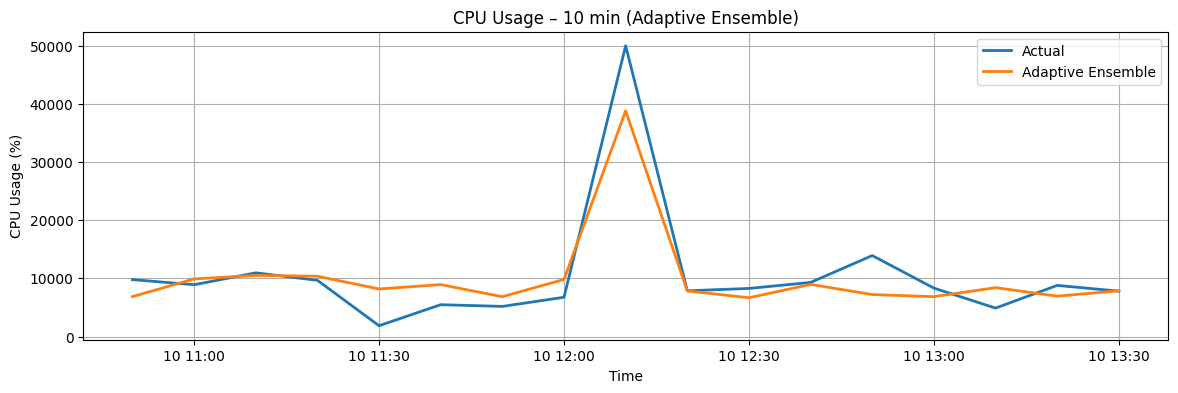

In [ ]:
plt.figure(figsize=(14,4))

plt.plot(
    aligned_index,
    aligned_y_true,
    label="Actual",
    linewidth=2
)

plt.plot(
    aligned_index,
    adaptive_preds,
    label="Adaptive Ensemble",
    linewidth=2
)

plt.title("CPU Usage – 10 min (Adaptive Ensemble)")
plt.xlabel("Time")
plt.ylabel("CPU Usage (%)")
plt.legend()
plt.grid(True)
plt.show()


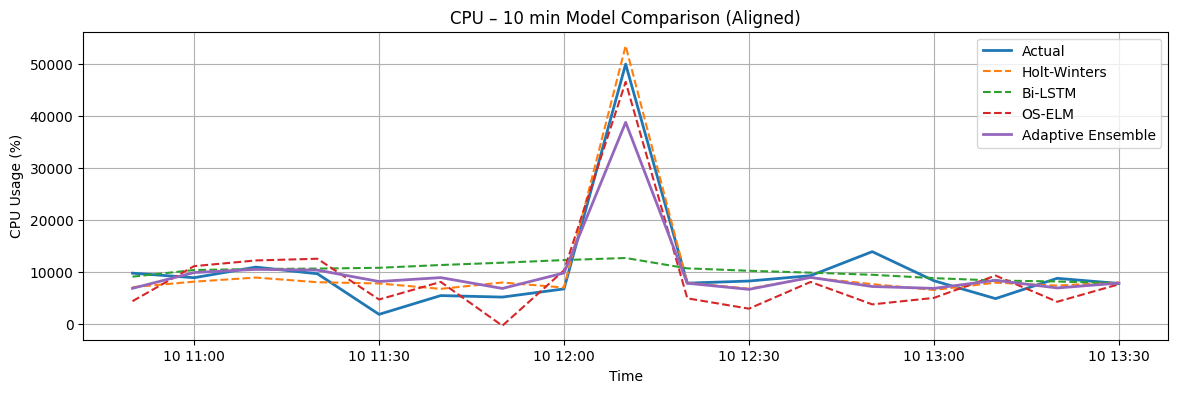

In [ ]:
plt.figure(figsize=(14,4))

plt.plot(
    aligned_index,
    aligned_y_true,
    label="Actual",
    linewidth=2
)

plt.plot(
    aligned_index,
    hw_preds[-L:],
    linestyle="--",
    label="Holt-Winters"
)

plt.plot(
    aligned_index,
    bilstm_preds[-L:],
    linestyle="--",
    label="Bi-LSTM"
)

plt.plot(
    aligned_index,
    oselm_preds[-L:],
    linestyle="--",
    label="OS-ELM"
)

plt.plot(
    aligned_index,
    adaptive_preds,
    linewidth=2,
    label="Adaptive Ensemble"
)

plt.title("CPU – 10 min Model Comparison (Aligned)")
plt.xlabel("Time")
plt.ylabel("CPU Usage (%)")
plt.legend()
plt.grid(True)
plt.show()


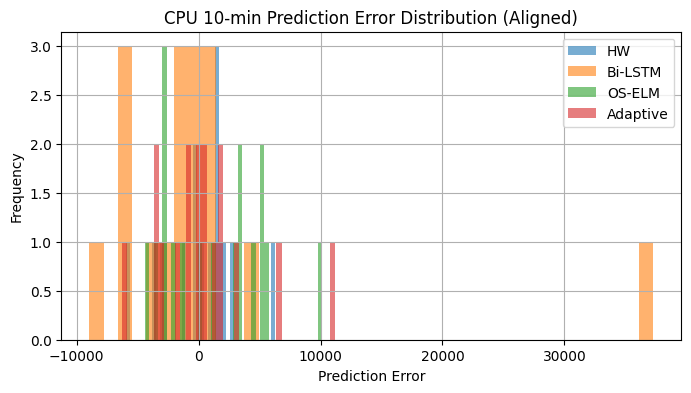

In [ ]:
plt.figure(figsize=(8,4))

plt.hist(aligned_y_true - hw_preds[-L:], bins=40, alpha=0.6, label="HW")
plt.hist(aligned_y_true - bilstm_preds[-L:], bins=40, alpha=0.6, label="Bi-LSTM")
plt.hist(aligned_y_true - oselm_preds[-L:], bins=40, alpha=0.6, label="OS-ELM")
plt.hist(aligned_y_true - adaptive_preds, bins=40, alpha=0.6, label="Adaptive")

plt.title("CPU 10-min Prediction Error Distribution (Aligned)")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
CPU_OVERLOAD_THRESHOLD = 0.9 * train_cpu.max()


In [ ]:
def overload_f1(y_true, y_pred, threshold):
    y_true_bin = (y_true > threshold).astype(int)
    y_pred_bin = (y_pred > threshold).astype(int)
    return f1_score(y_true_bin, y_pred_bin)


In [ ]:
print("F1 Scores (CPU 10-min Overload Detection)\n")

print("Holt-Winters      :", overload_f1(y_true, hw_preds, CPU_OVERLOAD_THRESHOLD))
print("Bi-LSTM           :", overload_f1(y_true, bilstm_preds, CPU_OVERLOAD_THRESHOLD))
print("OS-ELM            :", overload_f1(y_true, oselm_preds, CPU_OVERLOAD_THRESHOLD))
print("Mean Ensemble     :", overload_f1(y_true, mean_preds, CPU_OVERLOAD_THRESHOLD))
print("Adaptive Ensemble :", overload_f1(y_true, adaptive_preds, CPU_OVERLOAD_THRESHOLD))


F1 Scores (CPU 10-min Overload Detection)

Holt-Winters      : 1.0
Bi-LSTM           : 1.0
OS-ELM            : 0.9696969696969697
Mean Ensemble     : 1.0
Adaptive Ensemble : 1.0


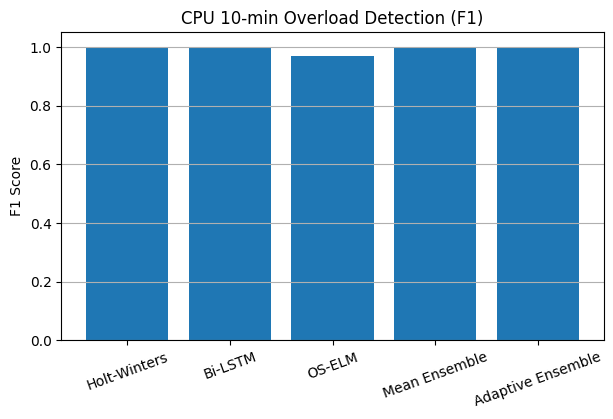

In [ ]:
f1_scores = {
    "Holt-Winters": overload_f1(y_true, hw_preds, CPU_OVERLOAD_THRESHOLD),
    "Bi-LSTM": overload_f1(y_true, bilstm_preds, CPU_OVERLOAD_THRESHOLD),
    "OS-ELM": overload_f1(y_true, oselm_preds, CPU_OVERLOAD_THRESHOLD),
    "Mean Ensemble": overload_f1(y_true, mean_preds, CPU_OVERLOAD_THRESHOLD),
    "Adaptive Ensemble": overload_f1(y_true, adaptive_preds, CPU_OVERLOAD_THRESHOLD)
}

plt.figure(figsize=(7,4))
plt.bar(f1_scores.keys(), f1_scores.values())
plt.ylabel("F1 Score")
plt.title("CPU 10-min Overload Detection (F1)")
plt.xticks(rotation=20)
plt.grid(axis="y")
plt.show()


In [ ]:
def sla_violations(y_pred, threshold):
    return np.sum(y_pred > threshold)


In [ ]:
print("SLA Violations (CPU 10-min)\n")

print("Holt-Winters      :", sla_violations(hw_preds, CPU_OVERLOAD_THRESHOLD))
print("Bi-LSTM           :", sla_violations(bilstm_preds, CPU_OVERLOAD_THRESHOLD))
print("OS-ELM            :", sla_violations(oselm_preds, CPU_OVERLOAD_THRESHOLD))
print("Mean Ensemble     :", sla_violations(mean_preds, CPU_OVERLOAD_THRESHOLD))
print("Adaptive Ensemble :", sla_violations(adaptive_preds, CPU_OVERLOAD_THRESHOLD))


SLA Violations (CPU 10-min)

Holt-Winters      : 17
Bi-LSTM           : 17
OS-ELM            : 16
Mean Ensemble     : 17
Adaptive Ensemble : 17


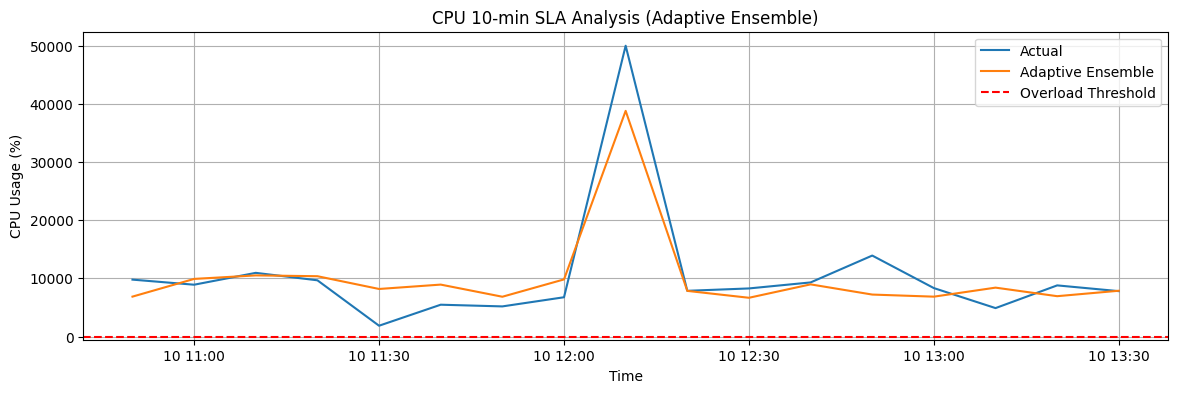

In [ ]:
plt.figure(figsize=(14,4))

plt.plot(
    aligned_index,
    aligned_y_true,
    label="Actual"
)

plt.plot(
    aligned_index,
    adaptive_preds,
    label="Adaptive Ensemble"
)

plt.axhline(
    CPU_OVERLOAD_THRESHOLD,
    color="red",
    linestyle="--",
    label="Overload Threshold"
)

plt.title("CPU 10-min SLA Analysis (Adaptive Ensemble)")
plt.xlabel("Time")
plt.ylabel("CPU Usage (%)")
plt.legend()
plt.grid(True)
plt.show()
